# Hyper-parameter Optimization Using Keras on Fashion MNIST

This notebook contains the code samples from the following sources:

https://www.youtube.com/watch?v=OLlWnW3Qpe4&feature=youtu.be

https://github.com/moustaphacheikh/youtube/blob/master/Hyperparameters_optimisation___Keras.ipynb

by Moustapha Cheikh.

# Objective

One of the biggest challenges when we are talking about Deep Learning is how to tune the hyper-parameters, this is a difficult part of the process that takes a lot of time and effort to be done. Here we will see how to test different combinations between different choices of hyperparameters.

In this Kernel we will try the following:

* Varying choices of **Activation Functions**: **relu** , **tanh** , **sigmoid** , **hard_sigmoid** and **linear**
* Different **Batch Size**: **20** , **50** and **100**
* Varying **Dropout rates**: **0.3** , **0.2** and **0.8**
* Different numbers of iterations or **epochs**: **1** , **20** and **50**
* Different **Initializers** or statistical distributions to use in order to generate the intitial weights of the Neural Network: **lecun_uniform** , **normal** , **he_normal** and      **he_uniform**
* Different **Learning Rates**: **0.1** , **0.001** and **0.02**
* Different number of neurons or **Number of Units**: **10** and **5**
* Different optimization algorithms or **optimizers** = **SGD** , **RMSprop** , **Adagrad** , **Adadelta** , **Adam** , **Adamax** and **Nadam**

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
import pprint
pp = pprint.PrettyPrinter(indent = 4)

Using TensorFlow backend.


In [3]:
import os
print(os.listdir("./input"))

['fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte']


# Reading the Training and Test Datasets

**Fashion-MNIST** is a dataset of Zalando's article images consisting of a **training** set of **60,000** examples and a **test** set of **10,000** examples. Each example is a **28x28** **grayscale** **image** for a total of **784 pixels**. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This **pixel-value** is an integer **between 0 and 255**.

Each image is associated with a label from 10 classes of clothes:

* **0** T-shirt/top
* **1** Trouser
* **2** Pullover
* **3** Dress
* **4** Coat
* **5** Sandal
* **6** Shirt
* **7** Sneaker
* **8** Bag
* **9** Ankle boot

In [4]:
train = "./input/fashion-mnist_train.csv"
test  = "./input/fashion-mnist_test.csv"

In [5]:
def read_dataset(data_file):
    df = pd.read_csv(data_file)
    label_column = 'label'
    y = df[label_column].values
    X = df.drop(label_column, axis=1).values
    return (X, y)

In [6]:
(x_train, y_train) = read_dataset(train)
(x_test, y_test) = read_dataset(test)

# Overview of the Training and Test Datasets

In [7]:
print("There are {} fashion images with {} pixels in x_train dataset. \n".format(x_train.shape[0],x_train.shape[1]))

print("There are {} fashion Labels in y_train dataset. \n".format(y_train.shape[0]))

print("There are {} fashion images with {} pixels in x_train dataset. \n".format(x_test.shape[0],x_test.shape[1]))

print("There are {} fashion Labels in y_test dataset. \n".format(y_test.shape[0]))

There are 60000 fashion images with 784 pixels in x_train dataset. 

There are 60000 fashion Labels in y_train dataset. 

There are 10000 fashion images with 784 pixels in x_train dataset. 

There are 10000 fashion Labels in y_test dataset. 



# How they look like?

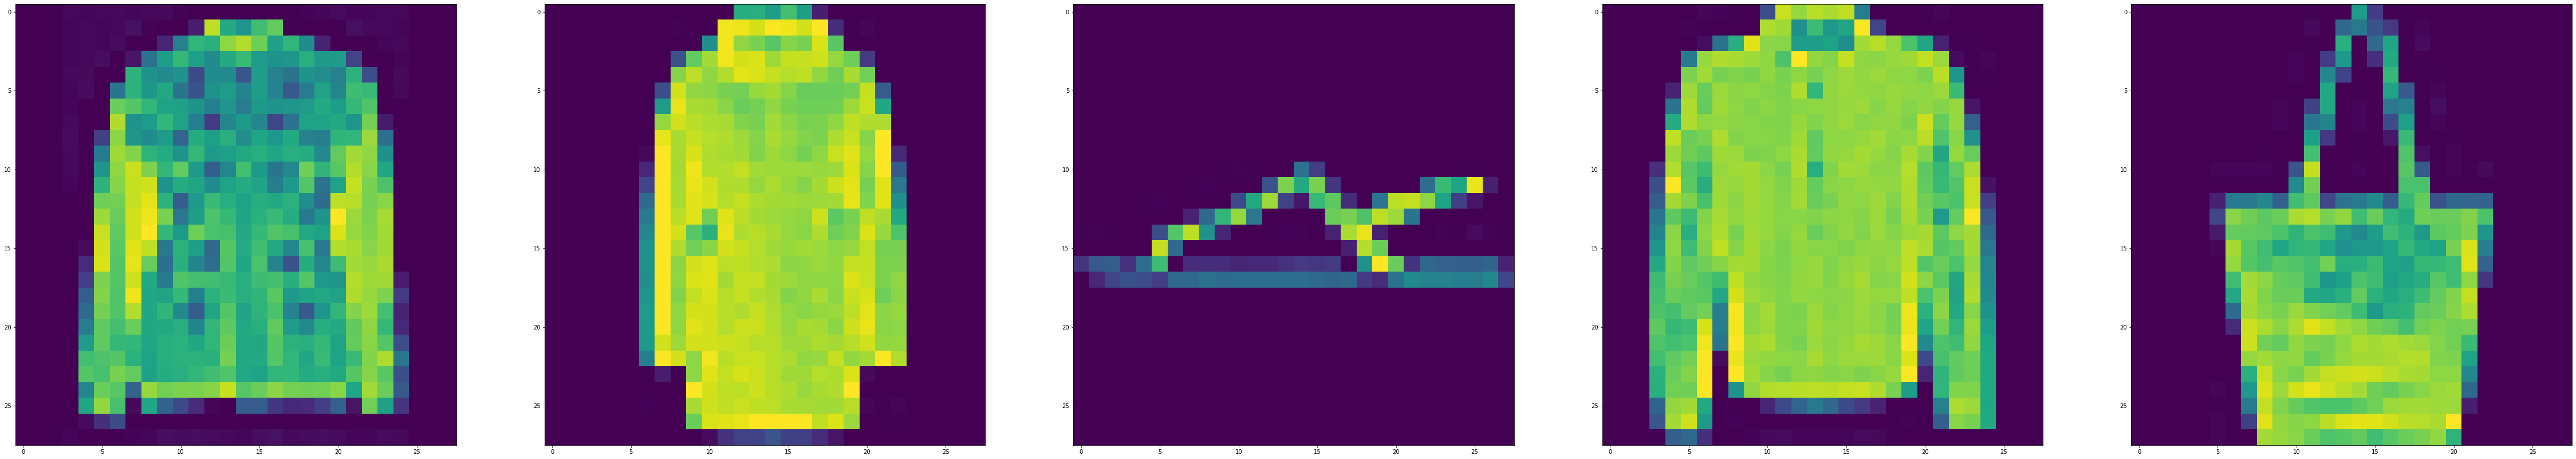

In [8]:
f, ax = plt.subplots(1,5)
f.set_size_inches(80, 40)
for i in range(5,10):
    ax[i-5].imshow(x_train[i].reshape(28, 28))
plt.show()

# Let's see each type of image with their corresponding Labels

In [9]:
def draw_articles(articles, labels):
    fig, axs = plt.subplots(1, len(articles), figsize=(30,30))
    for i in range(len(articles)):
        axs[i].set_title(labels[i])
        axs[i].imshow(articles[i].reshape((28,28)), cmap=plt.cm.binary)
    plt.show()

In [10]:
def ImageDisplay(list_data, label, one_hot=False):
    fig = pyplot.figure()
    axis = fig.add_subplot(1,1,1)
    list_data=np.reshape(list_data, (28,28))
    plot_img = axis.imshow(list_data, cmap=mpl.cm.Greys)
    plot_img.set_interpolation('none')
    if one_hot :
        ShowLabelName (label)
    else:
        print ("Label : "+str(CLASSES[str(label)]))

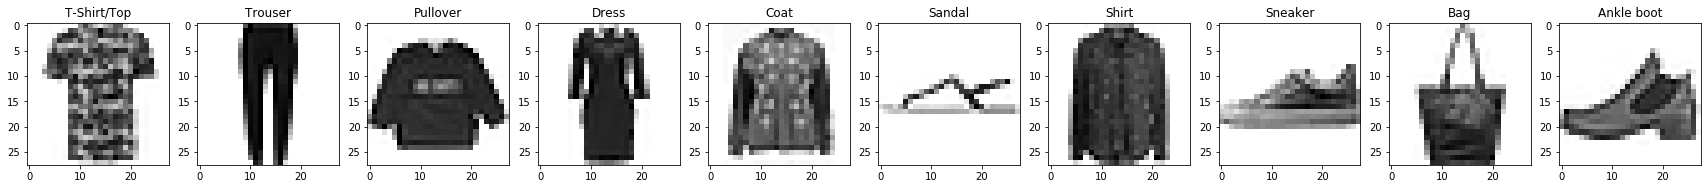

In [11]:
label_map = {0: 'T-Shirt/Top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
examples = []
labels = []

for i in label_map:
    k = np.where(y_train==i)[0][0]
    examples.append(x_train[k])
    labels.append(label_map[i])
draw_articles(examples, labels)

# Standardization and Categorization

* Here we are going to standardize all those pixel-values from 0-255 to 0-1. This will allow us to increase the performance of model calculations.

* By the other hand, we will change the labels (our y variable) from integers to categorical variables

In [12]:
x_train = x_train.astype('float32') / 255
y_train = to_categorical(y_train)

x_test = x_test.astype('float32') / 255
y_test = to_categorical(y_test)

# Model Definition

The following lines of code will allow us define Our Neural Network Architecture with:

* 1 input layer of 784 neurons
* 1 Hidden layer
* 2 Dropout Layers
* 1 output layer of 10 classes

As well, we will define the hyperparameters objects that will take the different choices that we have mentioned.

In [13]:
def build_model(optimizer, learning_rate, activation, dropout_rate,
                initializer,num_unit):
    keras.backend.clear_session()
    model = Sequential()
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation, input_shape=(784,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_unit, kernel_initializer=initializer,
                    activation=activation))
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer(lr=learning_rate),
                  metrics=['accuracy'])
    return model

# Define Hyper-Parameters Values

We are going to assign the values that each hyper-parameter can take.

In [14]:
# [:1] is for testing

batch_size = [20, 50, 100][:1]

epochs = [1, 20, 50][:1]

initializer = ['lecun_uniform', 'normal', 'he_normal', 'he_uniform'][:1]

learning_rate = [0.1, 0.001, 0.02][:1]

dropout_rate = [0.3, 0.2, 0.8][:1]

num_unit = [10, 5][:1]

activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'][:1]

optimizer = [SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam][:1]

# Model Wrapper and GridSearch

Now the intention is to test all the posible combinations between the hyper-parameters that we have defined in order to determine the optimal values that will enhance the performance of our model, letting us know the best set up for them.

In [15]:
# Creat the wrapper and pass params to GridSearchCV 
# parameters is a dict with all values

parameters = dict(batch_size = batch_size,
                  epochs = epochs,
                  dropout_rate = dropout_rate,
                  num_unit = num_unit,
                  initializer = initializer,
                  learning_rate = learning_rate,
                  activation = activation,
                  optimizer = optimizer)

model = KerasClassifier(build_fn=build_model, verbose=0)

models = GridSearchCV(estimator = model, param_grid=parameters, n_jobs=1)

# Train the Models

In [16]:
best_model = models.fit(x_train, y_train)
print('Best model :')
pp.pprint(best_model.best_params_)

/Users/auy212-admin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)



Best model :
{   'activation': 'relu',
    'batch_size': 20,
    'dropout_rate': 0.3,
    'epochs': 1,
    'initializer': 'lecun_uniform',
    'learning_rate': 0.1,
    'num_unit': 10,
    'optimizer': <class 'keras.optimizers.SGD'>}


# Results

The previous result let us see that this is the optimal configuration considering the given hypper-parameter values:

* Activation Function = relu
* Batch Size = 20
* Dropout Rate = 0.3
* epochs = 1
* Initializers = lecun_uniform
* Learning Rate = 0.1
* Number of Units = 10
* Optimizers = SGD